In [2]:
import math
import collections

import pandas as pd

from keras.models import Model, Sequential
from keras.layers import *

import params
from utils.sequence_data import generator_for_binary_classifier, generator_to_samples_and_targets
from utils.metrics import print_report_for_binary_classfier
from utils.preprocessing import probs_to_binary_classes
from utils.plot import plot_train_validation_metric


Using TensorFlow backend.


In [4]:
dataset = pd.read_csv("../datasets/data_for_models/dataset_1996-01-01_2019-05-01.csv",
                           header=0, parse_dates=[0], index_col=0)

#params for generator
label_index = len(dataset.columns) -1
input_shape = (params.LOOKBACK//params.STEP, dataset.shape[-1] )

In [4]:
train_max_idx = math.ceil(len(dataset)*params.TRAIN_RATIO)
val_max_idx = math.ceil(len(dataset)*(params.TRAIN_RATIO+params.VAL_RATIO))

# 1 step = 1 batche of samples 
train_steps = (train_max_idx+1 -params.LOOKBACK) // params.BATCH_SIZE
val_steps =  (val_max_idx - train_max_idx - params.LOOKBACK) // params.BATCH_SIZE
test_steps = (len(dataset) - val_max_idx - params.LOOKBACK) // params.BATCH_SIZE

In [7]:
#init generator_for_binary_classifiers
train_gen = generator_for_binary_classifier(dataset.to_numpy(),
                      label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=0,
                      max_index=train_max_idx,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)



val_gen = generator_for_binary_classifier(dataset.to_numpy(),
                    label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=train_max_idx+1,
                      max_index=val_max_idx,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)

test_gen = generator_for_binary_classifier(dataset.to_numpy(),
                      label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=val_max_idx+1,
                      max_index=None,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)


In [11]:
#build LSTM model from the book

hidden_units = 32
epochs = 20
l2_weight = 0.001

input_shape = (None, dataset.shape[-1] )

model = Sequential()
model.add(LSTM(hidden_units, input_shape=input_shape))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

# #fit the model
history = model.fit_generator(train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=epochs, verbose=0)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                7296      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 7,329
Trainable params: 7,329
Non-trainable params: 0
_________________________________________________________________
None


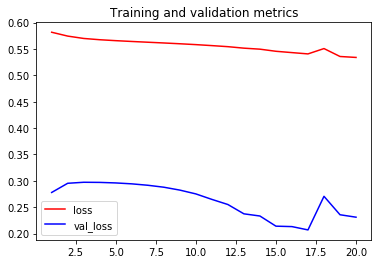

In [12]:
plot_train_validation_metric(history, 'loss', 'val_loss')

In [13]:
neg = 2762+158
pos = 177+807
print("We have {0} neg cases and {1} pos cases from train data".format(neg,pos))
print("the common sense baseline (accuracy score) is {0}".format(neg/(pos+neg)))

We have 2920 neg cases and 984 pos cases from train data
the common sense baseline (accuracy score) is 0.7479508196721312


In [14]:
#Make predictions for train set
    
X, Y = generator_to_samples_and_targets(train_gen, train_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 2920, 1.0: 984})
F1 score: 0.163636
precision score: 0.775862
recall score: 0.091463
accuracy score: 0.764344
matthews_corrcoef: 0.211116

Confusion matrix:
[[2894   26]
 [ 894   90]]


In [15]:
#Make predictions from dev set
X, Y = generator_to_samples_and_targets(val_gen, val_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 821, 1.0: 11})
F1 score: 0.000000
precision score: 0.000000
recall score: 0.000000
accuracy score: 0.985577
matthews_corrcoef: -0.004015

Confusion matrix:
[[820   1]
 [ 11   0]]


In [ ]:
#Make predictions for test set
X, Y = generator_to_samples_and_targets(test_gen, test_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))